In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
import PIL
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow_io")

In [2]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential  # Use tensorflow.keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Use tensorflow.keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, DenseNet121
from itertools import chain
import tensorflow as tf

# Ensure the following imports also use tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [3]:
BATCH_SIZE = 48

image_height = 299
image_width = 299

In [4]:
# Data agumentation and pre-processing using tensorflow
data_generator_1 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=5,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            brightness_range = [0.95,1.05],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'                                   
                        )

print('Data Augmentation 1 was created')

data_generator_2 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,
                            brightness_range = [0.9,1.1],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'                                   
                        )
print('Data Augmentation 2 was created')

data_generator_3 = ImageDataGenerator (rescale=1./255)

Data Augmentation 1 was created
Data Augmentation 2 was created


In [5]:
# Read the image
train_generator1 = data_generator_1.flow_from_directory(
    directory = "D:\my work and entertainment\mini sem 5 own\Detect_solar_dust", # images data path / folder in which images are there
#     subset = 'training',
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 1234)

test_generator = data_generator_2.flow_from_directory(
    directory = "D:\my work and entertainment\mini sem 5 own\Detect_solar_dust", # images data path / folder in which images are there
#     subset = 'validation',
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 1234)

Found 3561 images belonging to 4 classes.
Found 3561 images belonging to 4 classes.


In [6]:
dict_class = train_generator1.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())  # storing class/breed names in a list
print('Class labels: {}'.format(class_names))

Dictionary: {'Clean': 0, 'Dusty': 1, 'test': 2, 'train': 3}
Class labels: ['Clean', 'Dusty', 'test', 'train']


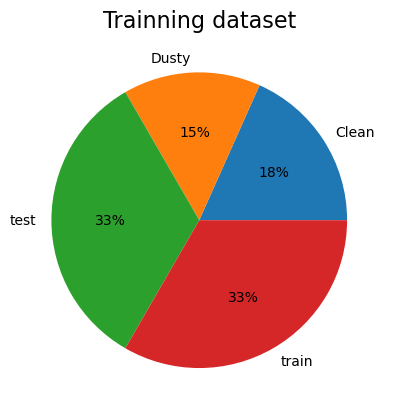

In [7]:
frequency = np.unique(train_generator1.classes, return_counts=True)

plt.title("Trainning dataset", fontsize='16')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%');

In [8]:
# Dataset characteristics
print("Dataset Characteristics of Train Data Set:")
print("Number of images:", len(train_generator1.classes))
print("Number of normal images:", len([label for label in train_generator1.classes if label == 0]))
print("Number of pneumonia images:", len([label for label in train_generator1.classes if label == 1]))
print()

print("Dataset Characteristics of Test Data Set:")
print("Number of images:", len(test_generator.classes))
print("Number of normal images:", len([label for label in test_generator.classes if label == 0]))
print("Number of pneumonia images:", len([label for label in test_generator.classes if label == 1]))
print()

Dataset Characteristics of Train Data Set:
Number of images: 3561
Number of normal images: 652
Number of pneumonia images: 535

Dataset Characteristics of Test Data Set:
Number of images: 3561
Number of normal images: 652
Number of pneumonia images: 535



In [9]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator1.classes), y= train_generator1.classes)
class_weights = dict(zip(np.unique(train_generator1.classes), class_weights))
class_weights

{0: 1.365414110429448, 1: 1.6640186915887851, 2: 0.75, 3: 0.75}

Train image data from Data Augmentation 1


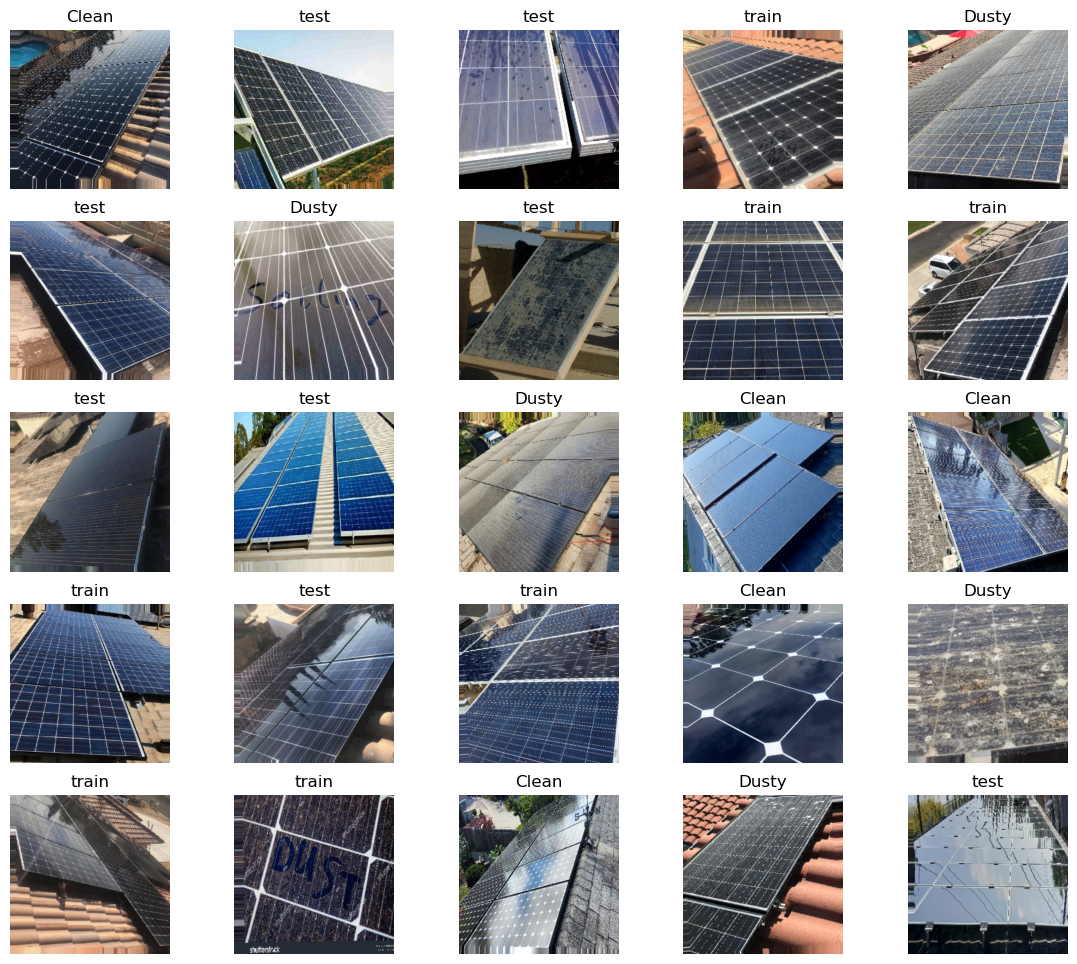

In [10]:
# Image Samples
print('Train image data from Data Augmentation 1')
img, label = next(train_generator1)
# print(len(label))

plt.figure(figsize=[14, 12])
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])    
plt.show()

In [11]:
# Define constants
EPOCHS = 25
BATCH_SIZE = 32
image_height, image_width = 224, 224  # InceptionV3 input size
train_data_dir = r'D:\my work and entertainment\mini sem 5 own\Detect_solar_dust\train'  # Training data path
test_data_dir = r'D:\my work and entertainment\mini sem 5 own\Detect_solar_dust\test'    # Testing data path

# Initialize ImageDataGenerators for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_height, image_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(image_height, image_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Compute class weights if needed for imbalanced data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Initialize a mirrored strategy for using multiple GPUs
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1'])

# Model configuration within the strategy scope
with strategy.scope():
    # Load pre-trained InceptionV3, excluding top layer
    base_model_Inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Freeze base model layers to prevent them from training
    for layer in base_model_Inception.layers:
        layer.trainable = False

    # Construct a new model with the InceptionV3 base
    model_Inception = Sequential()
    model_Inception.add(base_model_Inception)

    # Add additional layers for the final classification
    model_Inception.add(GlobalAveragePooling2D())
    model_Inception.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_Inception.add(Dropout(0.4))
    model_Inception.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_Inception.add(Dropout(0.2))
    model_Inception.add(Dense(2, activation='softmax'))

    # Display model architecture
    print("Model Summary (InceptionV3):")
    model_Inception.summary()

    # Compile the model with Adam optimizer and categorical crossentropy loss
    model_Inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)

# Train the model with EarlyStopping
history_Inception = model_Inception.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

# Validate the model
val_loss_Inception, val_accuracy_Inception = model_Inception.evaluate(test_generator, steps=len(test_generator))
print(f'Validation Loss: {val_loss_Inception:.4f}')
print(f'Validation Accuracy: {val_accuracy_Inception:.4f}') 




Found 1187 images belonging to 2 classes.
Found 1187 images belonging to 2 classes.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:1',)
Model Summary (InceptionV3):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,073,442 (84.20 MB)

 Trainable params: 270,658 (1.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

C:\Users\91965\Anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1/25
26/38 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.5704 - loss: 1.1073

C:\Users\91965\Anaconda3\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 216s 5s/step - accuracy: 0.5786 - loss: 1.0863 - val_accuracy: 0.6201 - val_loss: 0.8863 - learning_rate: 0.0010
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 223s 6s/step - accuracy: 0.6809 - loss: 0.8921 - val_accuracy: 0.8062 - val_loss: 0.7186 - learning_rate: 0.0010
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - accuracy: 0.7552 - loss: 0.7766 - val_accuracy: 0.8012 - val_loss: 0.6783 - learning_rate: 0.0010
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 196s 5s/step - accuracy: 0.7689 - loss: 0.7258 - val_accuracy: 0.8071 - val_loss: 0.6456 - learning_rate: 0.0010
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 199s 5s/step - accuracy: 0.7661 - loss: 0.6865 - val_accuracy: 0.8475 - val_loss: 0.6173 - learning_rate: 0.0010
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 192s 5s/step - accuracy: 0.7731 - loss: 0.6564 - val_accuracy: 0.7970 - val_loss: 0.6082 - learning_rate: 0.0010
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 187s 5s/step - accuracy: 0.7752 - loss: 0.6482 - val_accuracy: 0.83

C:\Users\91965\Anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [12]:
# Save the trained model to an .h5 file
model_Inception.save("dust_detection_model.h5")

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model_Inception, show_shapes=True, show_layer_names=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [19]:
pip install pydot

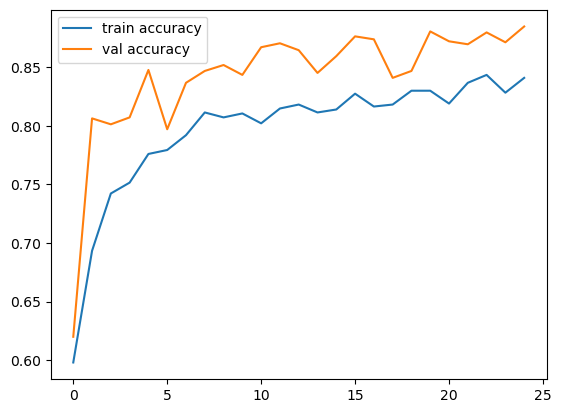

In [21]:
plt.plot(history_Inception.history['accuracy'],label='train accuracy')
plt.plot(history_Inception.history['val_accuracy'],label='val accuracy')
plt.legend()
plt.show()

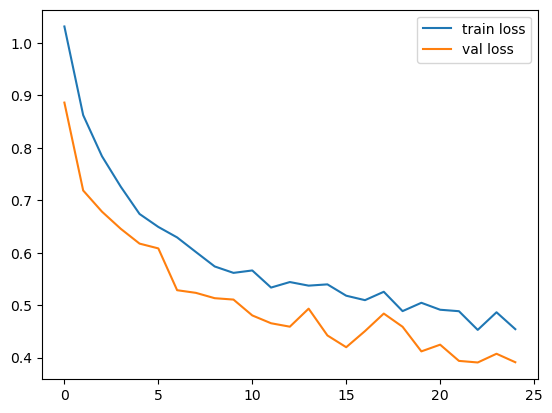

<Figure size 640x480 with 0 Axes>

In [22]:
plt.plot(history_Inception.history['loss'],label='train loss')
plt.plot(history_Inception.history['val_loss'],label='val loss')
plt.legend()
plt.show()
plt.savefig("LossVal_loss")

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


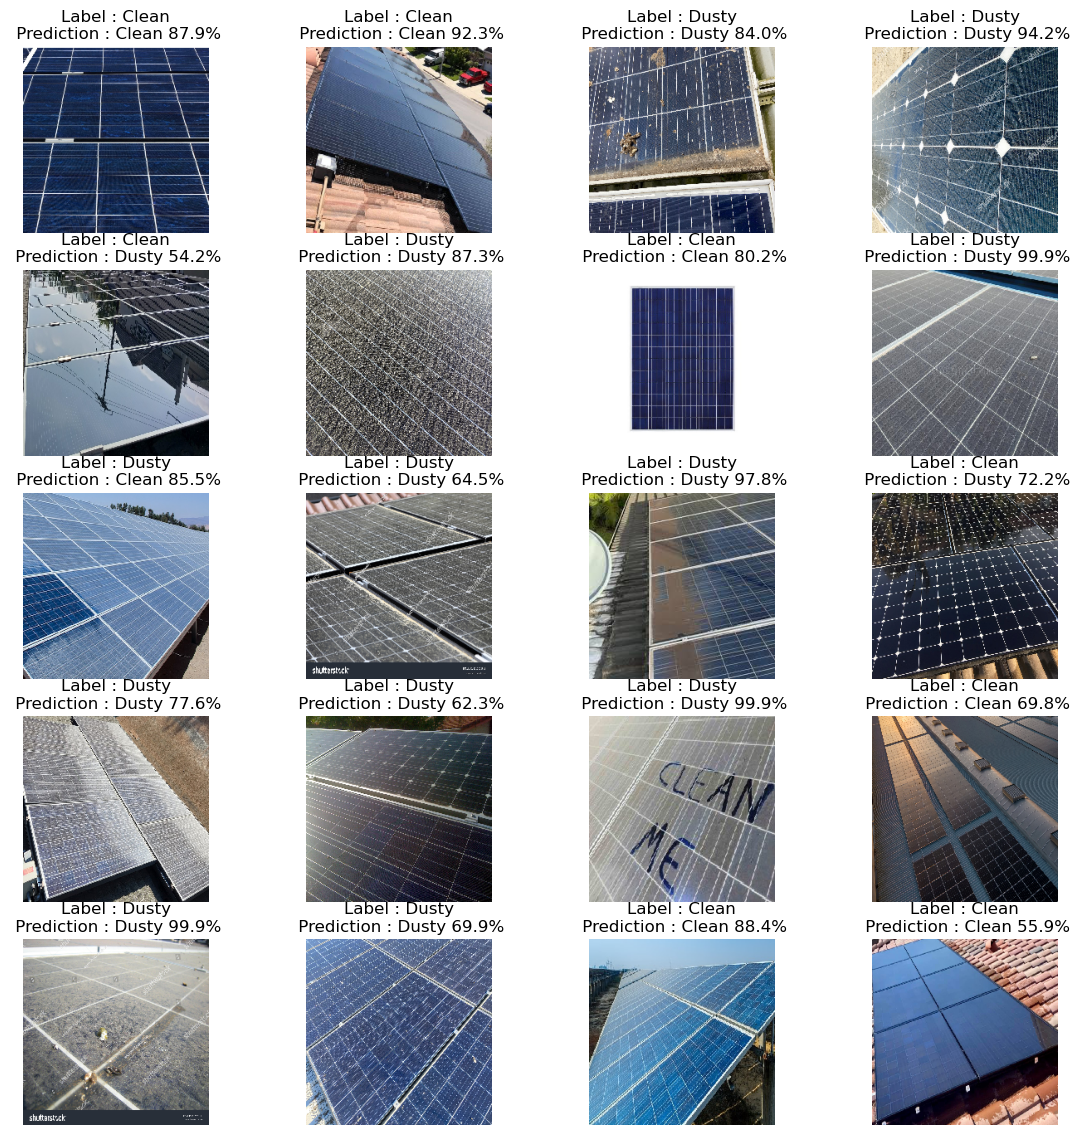

In [23]:
test_generator.reset()
img, label = next(test_generator)

prediction = model_Inception.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[14, 14])
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()

In [27]:
model_Inception.save("dust_detection_model.h5")